In [85]:
# Import packages

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_mccd_psf_field as tf_mccd_psf_field
import wf_psf.tf_psf_field as tf_psf_field
import wf_psf.metrics as wf_metrics
import wf_psf.train_utils as wf_train_utils
import wf_psf.script_utils as wf_script_utils

# Plot style & colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


# Create model

In [165]:
args = {
    'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/interp_SEDs/',
    #'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/more_stars/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_009_8_bins_sigma_0.npy',
    #'train_dataset_file': 'train_Euclid_res_3000_TrainStars_id_008_wfeRes_128.npy',
    'test_dataset_file': 'test_Euclid_res_id_009_8_bins.npy',
    #'test_dataset_file': 'test_Euclid_res_id_008_wfeRes_128.npy',
    'n_zernikes': 15,
    'pupil_diameter': 256,
    #'pupil_diameter': 128,
    'n_bins_lda':8,
    #'n_bins_lda':8,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,
    'chkp_save_path':'../wf-outputs/chkp/8_bins/chkp_callback_poly_9_cycles_256_proj_d2_cycle9',
    #'chkp_save_path':'../../more_stars/wf-outputs/chkp/3000_stars/chkp_callback_poly_full_poly_3000_stars_cycle2',
}

In [166]:
## Prepare the inputs
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(
    n_zernikes=args['n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it, :, :] = zernikes[it]
np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)
print('Zernike cube:')
print(tf_zernike_cube.shape)

# Generate ground truth Zernike maps
zernikes_gt = wf_utils.zernike_generator(
    n_zernikes=args['gt_n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube_gt = np.zeros((len(zernikes_gt), zernikes_gt[0].shape[0], zernikes_gt[0].shape[1]))
for it in range(len(zernikes_gt)):
    np_zernike_cube_gt[it, :, :] = zernikes_gt[it]
np_zernike_cube_gt[np.isnan(np_zernike_cube_gt)] = 0
tf_zernike_cube_gt = tf.convert_to_tensor(np_zernike_cube_gt, dtype=tf.float32)
print('Ground truth Zernike cube:')
print(tf_zernike_cube_gt.shape)

Zernike cube:
(15, 256, 256)
Ground truth Zernike cube:
(45, 256, 256)


In [167]:
## Generate initializations
# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args['n_zernikes'],
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

In [168]:
tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
            zernike_maps=tf_zernike_cube,
            obscurations=tf_obscurations,
            batch_size=args['batch_size'],
            output_Q=args['output_q'],
            d_max_nonparam=args['d_max_nonparam'],
            l2_param=args['l2_param'],
            output_dim=args['output_dim'],
            n_zernikes=args['n_zernikes'],
            d_max=args['d_max'],
            x_lims=args['x_lims'],
            y_lims=args['y_lims']
        )


# Load trained weights

In [169]:
weights_paths = args['chkp_save_path']

# Load the model's weights
tf_semiparam_field.load_weights(weights_paths)

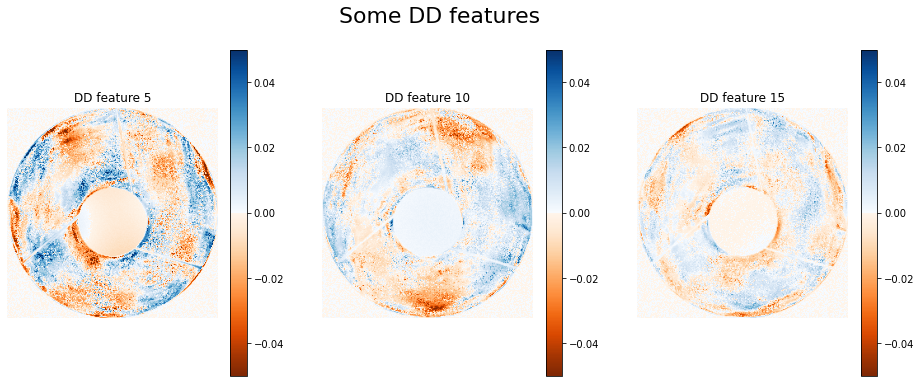

In [170]:
fig, ax = plt.subplots(1, 3, figsize=(16,6), facecolor='white')
fig.suptitle('Some DD features', fontsize=22)

for itr in range(3):
    im = ax[itr].imshow(tf_semiparam_field.tf_np_poly_opd.S_mat[5*itr+5,:,:],cmap=newcmp, vmin=-0.05, vmax=0.05)
    plt.colorbar(im, ax=ax[itr])
    ax[itr].set_xticks([])
    ax[itr].set_title('DD feature {}'.format(5*itr+5))


for axis in ax.ravel():
    axis.axis('off')

#plt.savefig('../outputs/plots/PSF_for_each_SED.pdf')
plt.show()

# Generate WFE and PSF

In [171]:
# Select any star from the 2000 test stars
test_star = 188

test_dataset = np.load(args['dataset_folder']+args['test_dataset_file'], allow_pickle=True)[()]
pos = test_dataset['positions'][test_star:test_star+1,:]

test_SEDs = test_dataset['SEDs']

In [172]:
# Ground truth WFE and WFE proyection on first 15 zernikes
param_opd_maps_GT = tf.tensordot(tf_zernike_cube_gt, tf.constant(test_dataset['zernike_coef'][test_star,:,0],dtype=tf.float32), axes=[0,0])
param_opd_maps_GT_low_Z = tf.tensordot(tf_zernike_cube, tf.constant(test_dataset['zernike_coef'][test_star,:args['n_zernikes'],0],dtype=tf.float32), axes=[0,0])

In [173]:
# Non parametric WFE
nonparam_opd_maps = tf_semiparam_field.tf_np_poly_opd(pos)
# Parametric WFE
zernike_coeffs = tf_semiparam_field.tf_poly_Z_field(pos)
zernike_coeffs=np.array(zernike_coeffs)
zernike_coeffs[0,0,0,0] = 0
param_opd_maps = tf_semiparam_field.tf_zernike_OPD(zernike_coeffs)
# Total WFE
opd_maps = param_opd_maps + nonparam_opd_maps

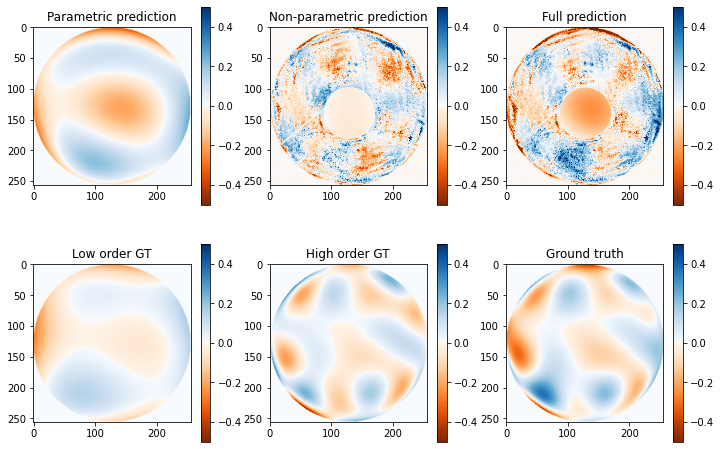

In [174]:
# Show parametric, non-parametric and total WFE
fig, ax = plt.subplots(2,3, figsize=(12,8))
im = ax[0][0].imshow(param_opd_maps[0,:,:], cmap=newcmp, vmax=0.5, vmin=-0.5)
ax[0][0].set_title('Parametric prediction')
plt.colorbar(im, ax=ax[0][0])
im = ax[0][1].imshow(nonparam_opd_maps[0,:,:], cmap=newcmp, vmax=0.5, vmin=-0.5)
ax[0][1].set_title('Non-parametric prediction')
plt.colorbar(im, ax=ax[0][1])
im = ax[0][2].imshow(opd_maps[0,:,:], cmap=newcmp, vmax=0.5, vmin=-0.5)
ax[0][2].set_title('Full prediction')
plt.colorbar(im, ax=ax[0][2])

im = ax[1][0].imshow(param_opd_maps_GT_low_Z, cmap=newcmp, vmax=0.5, vmin=-0.5)
ax[1][0].set_title('Low order GT')
plt.colorbar(im, ax=ax[1][0])
im = ax[1][1].imshow(param_opd_maps_GT-param_opd_maps_GT_low_Z, cmap=newcmp, vmax=0.5, vmin=-0.5)
ax[1][1].set_title('High order GT')
plt.colorbar(im, ax=ax[1][1])
im = ax[1][2].imshow(param_opd_maps_GT, cmap=newcmp, vmax=0.5, vmin=-0.5)
ax[1][2].set_title('Ground truth')
plt.colorbar(im, ax=ax[1][2])

plt.show()

## Get poly PSF

In [80]:
packed_SED_data = [
        wf_utils.generate_packed_elems(_sed, simPSF_np, n_bins=args['n_bins_lda'])
        for _sed in test_SEDs
    ]

# Prepare the inputs for the training
tf_packed_SED_data = tf.convert_to_tensor(packed_SED_data, dtype=tf.float32)
tf_packed_SED_data = tf.transpose(tf_packed_SED_data, perm=[0, 2, 1])

In [81]:
poly_psfs = tf_semiparam_field.tf_batch_poly_PSF([opd_maps, tf_packed_SED_data[test_star:test_star+1,:,:]])

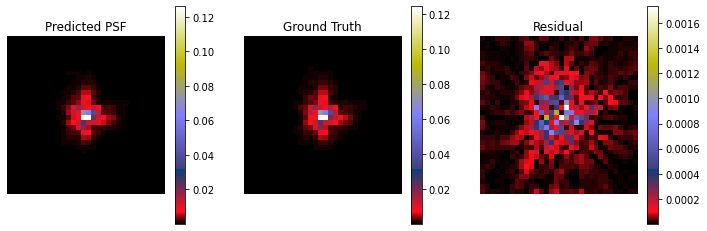

In [82]:
# Show parametric, non-parametric and total WFE
fig, ax = plt.subplots(1,3, figsize=(12,4))
im = ax[0].imshow(poly_psfs[0,:,:], cmap='gist_stern')
plt.colorbar(im, ax=ax[0])
ax[0].axis('off')
ax[0].set_title('Predicted PSF')
im = ax[1].imshow(test_dataset['stars'][test_star,:,:], cmap='gist_stern')
plt.colorbar(im, ax=ax[1])
ax[1].axis('off')
ax[1].set_title('Ground Truth')
im = ax[2].imshow(np.abs(poly_psfs[0,:,:]-test_dataset['stars'][test_star,:,:]), cmap='gist_stern')
plt.colorbar(im, ax=ax[2])
ax[2].axis('off')
ax[2].set_title('Residual')

plt.show()

# Metrics

In [95]:
metrics_file = '../wf-outputs/metrics/metrics-poly_%s_cycles_256_%s_d%s.npy'
dataset_list = [('2', 'no_proj', '2'),('2', 'proj', '2'),('2', 'no_proj', '5'),('2', 'proj', '5'),('5', 'no_proj', '2'),('5', 'proj', '2'),('5', 'proj', '5'),('9', 'no_proj', '2'),('9', 'proj', '2'),('9', 'proj', '5')]

In [96]:
metrics_dict_list = wf_script_utils.extract_shape_pix_results([np.load(metrics_file % dataset, allow_pickle=True)[()] for dataset in dataset_list ])

In [106]:
print('n cycles | project | d_max param |      SR RMSE\n')
for idx, dataset in enumerate(dataset_list):
    print('%s cycles - %s - d_max=%s' % dataset, ' ---> ', metrics_dict_list[2][idx])

n cycles | project | d_max param |      SR RMSE

2 cycles - no_proj - d_max=2  --->  2.830294333398342
2 cycles - proj - d_max=2  --->  4.590891674160957
2 cycles - no_proj - d_max=5  --->  5.00679686665535
2 cycles - proj - d_max=5  --->  4.427396133542061
5 cycles - no_proj - d_max=2  --->  5.398749187588692
5 cycles - proj - d_max=2  --->  3.7449821829795837
5 cycles - proj - d_max=5  --->  3.724740445613861
9 cycles - no_proj - d_max=2  --->  4.352663829922676
9 cycles - proj - d_max=2  --->  5.13378232717514
9 cycles - proj - d_max=5  --->  5.048232153058052
